## Stanford Open Policing Project Data - 
 ### all data here presented can be obtained from the following website: https://openpolicing.stanford.edu

Let's start by importing all the **libraries** which will be used in this project and then load the database in the **workplace**. Check how the first 5 **rows** look:

In [193]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import json
import warnings
from folium.plugins import HeatMap
from shapely.geometry import MultiPolygon, Polygon, Point, shape
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('ignore')
sns.set()

#loading the dataset
file_path = '../Desktop/datasets/new_orleans.csv'
new_orleans = pd.read_csv(file_path, low_memory = False)
new_orleans.head().style


,raw_row_number,date,time,location,lat,lng,district,zone,subject_age,subject_race,subject_sex,officer_assignment,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_color,vehicle_make,vehicle_model,vehicle_year
0,1,2010-01-01,01:11:00,nan,nan,nan,6,E,26,black,female,6th District,vehicular,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TRAFFIC VIOLATION,BLACK,DODGE,CARAVAN,2005
1,2,2010-01-01,02:06:00,nan,nan,nan,5,D,17,black,male,5th District,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CALL FOR SERVICE,nan,nan,nan,nan
2,3,2010-01-01,02:06:00,nan,nan,nan,5,D,18,black,male,5th District,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CALL FOR SERVICE,nan,nan,nan,nan
3,4,2010-01-01,02:06:00,nan,nan,nan,5,D,30,black,male,5th District,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CALL FOR SERVICE,nan,nan,nan,nan
4,5,2010-01-01,02:06:00,nan,nan,nan,5,D,21,black,male,5th District,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CALL FOR SERVICE,nan,nan,nan,nan


#### That was the first step: getting and loading the database.
That was a very simple process, but it is not always like this. Sometimes the data scientists will need to **collect** the data using a web scrapper or get it from an **API**, for example. In this cause, the csv file was downloaded from a repository on the internet. 

From now on, data will start to be explored using some Pandas' methods and some cleaning will be done.

#### Second step: cleaning 

In [194]:
new_orleans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513065 entries, 0 to 513064
Data columns (total 30 columns):
raw_row_number        513065 non-null int64
date                  513055 non-null object
time                  513065 non-null object
location              416421 non-null object
lat                   260624 non-null float64
lng                   260624 non-null float64
district              513065 non-null int64
zone                  513065 non-null object
subject_age           499880 non-null float64
subject_race          500938 non-null object
subject_sex           500938 non-null object
officer_assignment    512941 non-null object
type                  362916 non-null object
arrest_made           389716 non-null object
citation_issued       389716 non-null object
warning_issued        389716 non-null object
outcome               335680 non-null object
contraband_found      75802 non-null object
contraband_drugs      75802 non-null object
contraband_weapons    75802 non-nul

As shown above, the database has **513065 entries**(observations) and **30 columns**. From this table, the scientist can see that there is a lot of information **missing**. For example, look at the **'search_basis'** column it only has **75802 non-null** values. 

During the first step, it was decided what columns were important to the analysis and **all the observations that had any of them missing were dropped.** In the second step, **all the columns that were not important to the analysis and the ones which have a lot of null values were dropped**. Finally,**the missing values that were still unaccounted for were filled** and the 'date' and 'time' columns were transformed **from object to datetime.**

In [195]:
#cleaning
new_orleans.dropna(how='any', subset=['lat', 'lng', 'search_person', 'search_vehicle', 
                                      'outcome', 'subject_race','subject_sex', 'date', 'time'], 
                   inplace = True)

new_orleans.drop(['contraband_found',
                 'contraband_drugs',
                 'contraband_weapons',
                 'vehicle_color',
                 'vehicle_model',
                  'vehicle_make',
                 'vehicle_year',
                  'type',
                  'officer_assignment',
                 'search_basis', 'location'], axis = 'columns',
                inplace = True)

age_mean = new_orleans.subject_age.mean()
new_orleans['subject_age'] = new_orleans.subject_age.fillna(age_mean)
new_orleans['date_time'] = new_orleans['date'] +' '+ new_orleans['time']
new_orleans['date_time'] = pd.to_datetime(new_orleans['date_time'])
new_orleans.drop(['date', 'time'], axis=1, inplace = True)

#### Verifying:

In [196]:
new_orleans.isnull().sum()

raw_row_number      0
lat                 0
lng                 0
district            0
zone                0
subject_age         0
subject_race        0
subject_sex         0
arrest_made         0
citation_issued     0
warning_issued      0
outcome             0
frisk_performed     0
search_conducted    0
search_person       0
search_vehicle      0
reason_for_stop     0
date_time           0
dtype: int64

#### Before moving on to the next step, it is important to make clear that dropping information is not always a good idea and It depends on what the scientist is trying to achieve. 

There are other methods to **fill null values** such as the one that was used for the column 'subject_age'. It is also important that the data scientists know your dataset so that they can decide either to exclude those values or fill them with an educated guess.

#### Third step: Exploratory Data Analysis

It is significant to mention that some exploration was already done in the database. These steps can go back and forth as many times as the scientists think is necessary.

Initially, four figures were created which tell people the frequency of the police activity depending on:
 - Gender
 - District
 - Race
 - Outcome


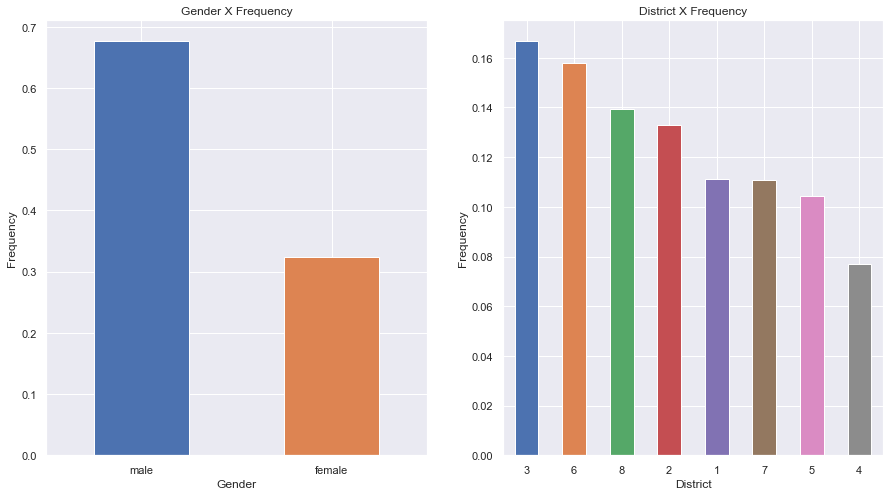

In [197]:
#plotting figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

_gender = new_orleans.subject_sex.value_counts(normalize = True).plot(ax = axes[0], kind='bar')
_gender.set_title('Gender X Frequency')
_gender.set_ylabel('Frequency')
_gender.set_xlabel('Gender')
_gender.set_xticklabels(list(new_orleans.subject_sex.value_counts().index),{'rotation': 0})

_district = new_orleans.district.value_counts(normalize = True).plot(ax = axes[1], kind='bar')
_district.set_title('District X Frequency')
_district.set_ylabel('Frequency')
_district.set_xlabel('District')
_district.set_xticklabels(list(new_orleans.district.value_counts().index),{'rotation': 0})

plt.show()

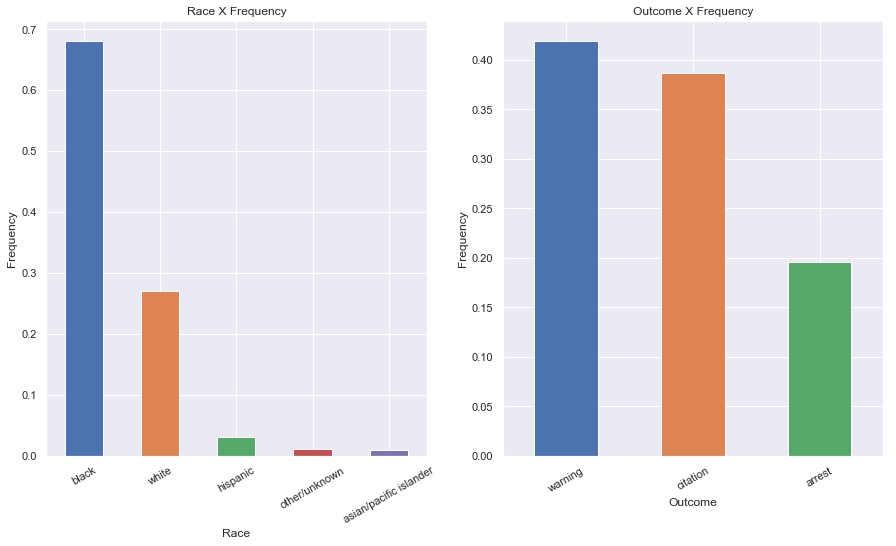

In [198]:
#plotting figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

_race = new_orleans.subject_race.value_counts(normalize = True).plot(ax = axes[0],kind='bar')
_race.set_title('Race X Frequency')
_race.set_ylabel('Frequency')
_race.set_xlabel('Race')
_race.set_xticklabels(list(new_orleans.subject_race.value_counts().index),{'rotation': 30})

_outcome = new_orleans.outcome.value_counts(normalize = True).plot(ax = axes[1],kind='bar')
_outcome.set_title('Outcome X Frequency')
_outcome.set_ylabel('Frequency')
_outcome.set_xlabel('Outcome')
_outcome.set_xticklabels(list(new_orleans.outcome.value_counts().index),{'rotation': 30})

plt.show()

To keep this notebook simple, only the four figures above will be drawn. It is good to mention, however, that from here the scientists can analyze a lot of aspects involving police activity. They can group the information by gender and see what's the most common output for women, for example, or they can see how the police activity dealt with men and how they are distributed depending on their race. The data scientist can also wonder why district three has the most elevated police activity. Is that because it is a dangerous region or is it just because it is a very common area that people go for fun? Has the police activity grown over the years?(**time series**) Is this activity effective?  

**From this data, the data scientist can find patterns, identify anomalies (return to cleaning if it is necessary), test hypothesis, and check suppositions.** 

Continuing with the EDA some information was added to **maps.** To do so, the libraries called **Folium and Shapely** were used. They allowed the scientists to plot maps and manipulate some data along with them. The first map that was plotted is called a **Choropleth** map and it basically needs two files to work properly:

The first file is a **geo-json** from New Orleans City. This file contains coordinates of the neighborhood borders and it will delimitit the regions that will be analyzed. The file can be downloaded at:
##### https://data.nola.gov/dataset/Neighborhood-Area-Boundary/7svi-kqix

The second file is a **dataframe** with the information to be shown. In this example, the 'police activity' will be displayed.

In [199]:
#loading geo-json file
nola_geo_path = '../Desktop/new_orleans.geojson'
nola_geo = json.load(open(nola_geo_path, encoding = 'UTF-8'))

In [200]:
# list comprehension to salve the multipolygon and its ids 
list_multi_reg = [(MultiPolygon(shape(nola_geo['features'][item]['geometry'])),
           nola_geo['features'][item]['properties']['objectid']) for item in range(72)]
# list of coordinates
lat = list(new_orleans['lat'])
lng = list(new_orleans['lng'])
list_zip = list(zip(lng, lat))

In [201]:
def points_and_regions(list_coord, list_polygon_region):
    '''
    list_coord: list of points' coordinates
    list_polygon_region: list of multipolygons and its ids
    it returns: list with the regions where the points belong
    '''
    list_of_points = []
    for coord in list_coord:
        pnt = Point(coord[0], coord[1])
        for (multi, region) in list_polygon_region:
            if multi.contains(pnt):
                list_of_points.append(region)
                
    return list_of_points

delimitations = pd.Series(points_and_regions(list_zip, list_multi_reg))

In [202]:
# it creates a dataframe with the region and the frequency of the police activity
points_df = pd.DataFrame({'region': list(delimitations.value_counts().index),
                         'values': list(delimitations.value_counts().values)})
points_df.head()

,region,values
0,877,20295
1,933,13001
2,876,12951
3,911,10786
4,921,7460


In [203]:
points_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
region    72 non-null object
values    72 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


After all the procedures were completed, the map was added:
##### You can get more information about the folium library at: 
https://python-visualization.github.io/folium/

In [212]:
# setting up the map
m = folium.Map(location = [29.951065, -90.071533], zoom_start = 11)
folium.Choropleth(
    geo_data=nola_geo,
    name='choropleth',
    data = points_df,
    columns = ['region', 'values'],
    key_on = 'feature.properties.objectid',
    fill_color = 'YlOrRd',
    fill_opacity=0.9,
    line_opacity=0.2,
).add_to(m)

folium.LayerControl().add_to(m)

m

The second map will be a **heatmap** also from folium. To build this one, the only necessary thing is the **coordinates** of the police activity:

In [219]:
f = folium.Map(location = [29.951065, -90.071533], zoom_start = 11)
HeatMap(list(zip(lat, lng)), min_opacity = 0.4, radius=2, blur = 2, 
        gradient = {0.6: 'blue', 0.75: 'green', 0.85: 'yellow', 1: 'red'}).add_to(f)
f.save('heatmap.html')

Now that EDA is done, the fourth and last step:
#### Fourth step: Modeling

In order to use the information in the database to build a **model** using scikit-learn, all columns need to be in **numeric form**. First, it was verified how many different values can be found in our dataframe columns. Then, dictionaries were built to map our objects to integers. Finally, the changes were applied to the dataframe.

In [205]:
for column in new_orleans.columns:
    print(column, len(new_orleans[column].value_counts()))
    

raw_row_number 214248
lat 8635
lng 8624
district 8
zone 25
subject_age 93
subject_race 5
subject_sex 2
arrest_made 2
citation_issued 2
warning_issued 2
outcome 3
frisk_performed 2
search_conducted 2
search_person 2
search_vehicle 2
reason_for_stop 10
date_time 188112


In [206]:
dict_zones = {} 
dict_races = {}
dict_reason_stop = {}
dict_outcome = {}
dict_bin = {False: 0,True: 1}
dict_sex = {'male': 0, 'female': 1}

for element in range(25):
    dict_zones[new_orleans['zone'].value_counts().index[element]] = element
    
for element in range(5):
    dict_races[new_orleans['subject_race'].value_counts().index[element]] = element
    
for element in range(10):
    dict_reason_stop[new_orleans['reason_for_stop'].value_counts().index[element]] = element
    
for element in range(3):
    dict_outcome[new_orleans['outcome'].value_counts().index[element]] = element
    
list_dict = [dict_zones, dict_races, dict_reason_stop, dict_outcome, dict_bin, dict_sex]


In [207]:
for dict_ in list_dict:
    new_orleans.replace(dict_, inplace= True)
    

For the classification problem, four classes of the scikit-learn package will be used:
- KNeighborsClassifier
- LogisticRegression
- SVC
- DecisionTreeClassifier

The main goal here is to predict the column named 'outcome' of the dataframe. For that, the Pipeline class also from scikit-learn was used.

In [208]:
new_orleans.head().style

,raw_row_number,lat,lng,district,zone,subject_age,subject_race,subject_sex,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,search_person,search_vehicle,reason_for_stop,date_time
93414,93415,29.9499,-90.1023,2,22,19,0,0,1,0,0,2,1,1,1,1,0,2011-05-06 14:59:00
93416,93417,29.9499,-90.1023,2,22,18,0,0,1,0,0,2,1,1,1,1,0,2011-05-06 14:59:00
93417,93418,29.9499,-90.1023,2,22,20,0,0,1,0,0,2,1,1,1,1,0,2011-05-06 14:59:00
93418,93419,29.9499,-90.1023,2,22,15,0,0,1,0,0,2,1,1,1,1,0,2011-05-06 14:59:00
93579,93580,29.943,-90.0411,4,5,32,0,0,0,1,0,1,0,0,1,0,0,2011-05-07 09:28:00


Before fitting the data into a model, the data was divided  into **training data and testing data.** it was also used a class called 'RandomizedSearchCV' (computational less expensive) for **hyperparameters tunning.** Finally, the **scores** of each one of the models built were printed.

In [209]:
# Setting up pipelines for the models 
y = new_orleans['outcome'].values
X = new_orleans.drop(['outcome', 'raw_row_number', 'date_time'], axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size= 0.37,
                                                    random_state=83)
                                                    
knn = KNeighborsClassifier(n_neighbors = 3)
log_reg = LogisticRegression()
svc = SVC(C = 0.5)
tree = DecisionTreeClassifier()

list_models = [knn, log_reg, svc, tree]
parameters_knn = {'model__n_neighbors': np.arange(1,6,1)}
parameters_svc = {'model__C': np.arange(0.3,1.0,0.3),
              'model__kernel': ['poly', 'rbf', 'sigmoid']}

parameters_tree = {'model__min_samples_split': np.arange(3,5,1),
              'model__min_samples_leaf': np.arange(2,4,1)}

for model in list_models:
    parameters = {}
    steps = [('model', model)]
    pipe = Pipeline(steps)
    if model == knn:
        parameters = parameters_knn
    if model == svc:
        parameters = parameters_svc
    if model == tree:
        parameters = parameters_tree
    model_cv = RandomizedSearchCV(pipe, param_distributions = parameters, cv = 2, n_jobs=2)
    model_cv.fit(X_train, y_train)
    print(f'{model} : {model_cv.score(X_test, y_test)}')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform') : 0.9585477848420628
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) : 1.0
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) : 1.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False